# Setup

#### Imports

In [1]:
import pathlib
import zipfile

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm

#### Print Library Versions

In [2]:
print(f'{pd.__version__ = }')
print(f'{pl.__version__ = }')

pd.__version__ = '2.2.2'
pl.__version__ = '1.0.0'


#### Reading and combining data from zip archives

In [3]:
data_pd = pd.DataFrame()
data_pl = pl.DataFrame()

zip_files_directory = pathlib.Path('zip_files/')
zip_filepaths = list(zip_files_directory.glob('*.zip'))

for zip_filepath in tqdm(zip_filepaths):
    with zipfile.ZipFile(zip_filepath) as czip:
        csv_name = zip_filepath.name.replace('.zip', '.csv')
        
        temp_pd = pd.read_csv(czip.open(csv_name))
        data_pd = pd.concat([data_pd, temp_pd])
        
        temp_pl = pl.read_csv(czip.read(csv_name))
        data_pl = pl.concat([data_pl, temp_pl])

data_pd = data_pd.reset_index(drop=True)

print(f'{data_pd.shape = }')
print(f'{data_pl.shape = }')

  0%|          | 0/12 [00:00<?, ?it/s]

data_pd.shape = (4091233, 13)
data_pl.shape = (4091233, 13)


#### Get list of column names

In [4]:
data_pl.columns

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual']

#### Create dictionary mapping date integers to day names

In [5]:
day_order = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday',
}

# Questions
- How does weekday ridership vary by member type?
- How does time of day ridership vary by member type?
- How did ridership vary over the year by member type?
- How does ride time vary by member type and bike type?

## Q1: How does weekday ridership vary by member type?

#### `pandas` implementation

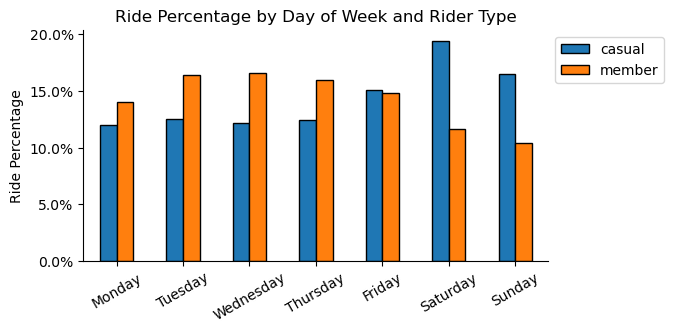

CPU times: user 5.38 s, sys: 614 ms, total: 5.99 s
Wall time: 6 s


In [6]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

weekday_ridership = data_pd[columns_to_keep].copy()

weekday_ridership['started_at'] = weekday_ridership['started_at'].str.split('.', expand=True)[0].copy()
weekday_ridership['started_at'] = pd.to_datetime(weekday_ridership['started_at'])
weekday_ridership['start_day_name'] = weekday_ridership['started_at'].dt.day_name()

weekday_ridership = weekday_ridership.groupby(
    ['member_casual', 'start_day_name']
).agg(
    unique_rides = ('ride_id', 'nunique')
).reset_index().pivot(
    index='start_day_name',
    columns='member_casual',
    values='unique_rides',
).loc[day_order.values()]

weekday_ridership = weekday_ridership.divide(
    weekday_ridership.sum(axis=0),
    axis=1,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

weekday_ridership.plot(
    kind='bar',
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_ylabel('Ride Percentage')
ax.set_title('Ride Percentage by Day of Week and Rider Type')

plt.show()

#### `polars` implementation

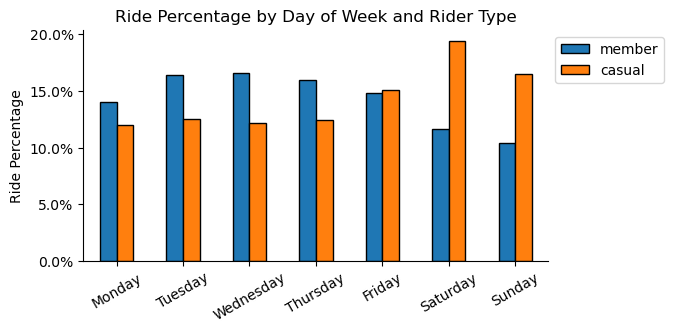

CPU times: user 1.95 s, sys: 725 ms, total: 2.68 s
Wall time: 430 ms


In [7]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

weekday_ridership = data_pl.select(
    columns_to_keep
).with_columns(
    pl.col('started_at').str.split('.').list[0]
).with_columns(
    pl.col('started_at').str.to_datetime(format='%Y-%m-%d %H:%M:%S')
).with_columns(
    start_day_int = pl.col('started_at').dt.weekday()
).with_columns(
    start_day_name = pl.col('start_day_int').replace_strict(day_order)
).group_by(
    ['member_casual', 'start_day_name']
).agg(
    unique_rides = pl.col('ride_id').n_unique()
).pivot(
    index='start_day_name',
    on='member_casual',
    values='unique_rides',
).with_columns(
    pl.all().exclude('start_day_name')/pl.all().exclude('start_day_name').sum()
).to_pandas().set_index(
    'start_day_name'
).loc[day_order.values()]
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

weekday_ridership.plot(
    kind='bar',
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_ylabel('Ride Percentage')
ax.set_title('Ride Percentage by Day of Week and Rider Type')

plt.show()

## Q2: How does time of day ridership vary by member type?

#### `pandas` implementation

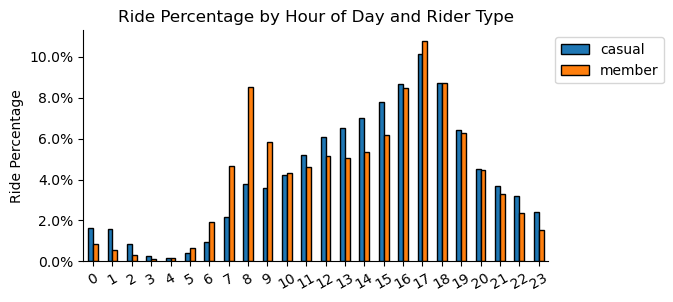

CPU times: user 4.55 s, sys: 503 ms, total: 5.06 s
Wall time: 5.06 s


In [8]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

hourly_ridership = data_pd[columns_to_keep].copy()

hourly_ridership['started_at'] = hourly_ridership['started_at'].str.split('.', expand=True)[0].copy()
hourly_ridership['started_at'] = pd.to_datetime(hourly_ridership['started_at'])
hourly_ridership['start_hour'] = hourly_ridership['started_at'].dt.hour

hourly_ridership = hourly_ridership.groupby(
    ['member_casual', 'start_hour']
).agg(
    unique_rides = ('ride_id', 'nunique')
).reset_index().pivot(
    index='start_hour',
    columns='member_casual',
    values='unique_rides',
)

hourly_ridership = hourly_ridership.divide(
    hourly_ridership.sum(axis=0),
    axis=1,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

hourly_ridership.plot(
    kind='bar',
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_ylabel('Ride Percentage')
ax.set_title('Ride Percentage by Hour of Day and Rider Type')

plt.show()

#### `polars` implementation

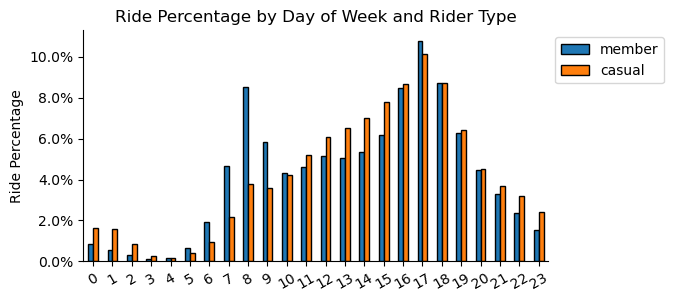

CPU times: user 1.9 s, sys: 422 ms, total: 2.32 s
Wall time: 399 ms


In [9]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

hourly_ridership = data_pl.select(
    columns_to_keep
).with_columns(
    pl.col('started_at').str.split('.').list[0]
).with_columns(
    pl.col('started_at').str.to_datetime(format='%Y-%m-%d %H:%M:%S')
).with_columns(
    start_hour = pl.col('started_at').dt.hour()
).group_by(
    ['member_casual', 'start_hour']
).agg(
    unique_rides = pl.col('ride_id').n_unique()
).pivot(
    index='start_hour',
    on='member_casual',
    values='unique_rides',
).with_columns(
    pl.all().exclude('start_hour')/pl.all().exclude('start_hour').sum()
).to_pandas().set_index(
    'start_hour'
).sort_index()
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

hourly_ridership.plot(
    kind='bar',
    edgecolor='k',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.tick_params(
    axis='x',
    labelrotation=30,
)
ax.set_ylabel('Ride Percentage')
ax.set_title('Ride Percentage by Day of Week and Rider Type')

plt.show()

## Q3: How did ridership vary over the year by member type?

#### `pandas` implementation

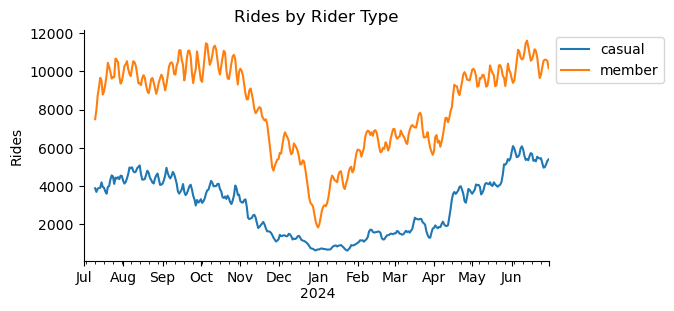

CPU times: user 5.16 s, sys: 542 ms, total: 5.71 s
Wall time: 5.7 s


In [10]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

daily_ridership = data_pd[columns_to_keep].copy()

daily_ridership['started_at'] = daily_ridership['started_at'].str.split('.', expand=True)[0].copy()
daily_ridership['started_at'] = pd.to_datetime(daily_ridership['started_at'])
daily_ridership['start_date'] = daily_ridership['started_at'].dt.date
daily_ridership['start_date'] = pd.to_datetime(daily_ridership['start_date'])

daily_ridership = daily_ridership.groupby(
    ['member_casual', 'start_date']
).agg(
    unique_rides = ('ride_id', 'nunique')
).reset_index().pivot(
    index='start_date',
    columns='member_casual',
    values='unique_rides',
)

daily_ridership['casual'] = daily_ridership['casual'].rolling(10).mean()
daily_ridership['member'] = daily_ridership['member'].rolling(10).mean()


fig, ax = plt.subplots(1, 1, figsize=(6, 3))

daily_ridership.plot(
    kind='line',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('Rides')
ax.set_title('Rides by Rider Type')

plt.show()

#### `polars` implementation

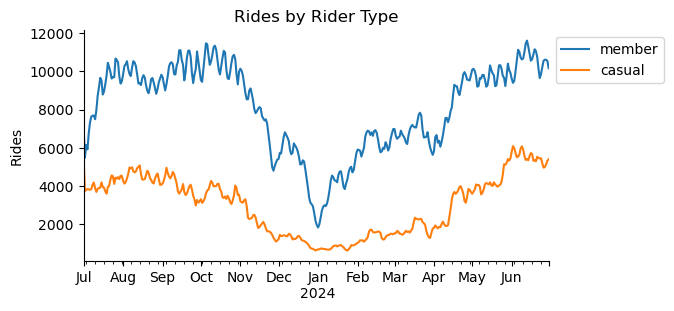

CPU times: user 1.55 s, sys: 410 ms, total: 1.96 s
Wall time: 400 ms


In [11]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'member_casual',
]

daily_ridership = data_pl.select(
    columns_to_keep
).with_columns(
    pl.col('started_at').str.split('.').list[0]
).with_columns(
    pl.col('started_at').str.to_datetime(format='%Y-%m-%d %H:%M:%S')
).with_columns(
    start_date = pl.col('started_at').dt.date()
).group_by(
    ['member_casual', 'start_date']
).agg(
    unique_rides = pl.col('ride_id').n_unique()
).pivot(
    index='start_date',
    on='member_casual',
    values='unique_rides',
).sort('start_date').rolling(
    index_column='start_date', 
    period='10d',
).agg(
    pl.all().exclude('start_date').mean()
).to_pandas().set_index('start_date')


fig, ax = plt.subplots(1, 1, figsize=(6, 3))

daily_ridership.plot(
    kind='line',
    ax=ax,
)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('Rides')
ax.set_title('Rides by Rider Type')

plt.show()

## Q4: How does ride time vary by member type and bike type?

#### `pandas` implementation

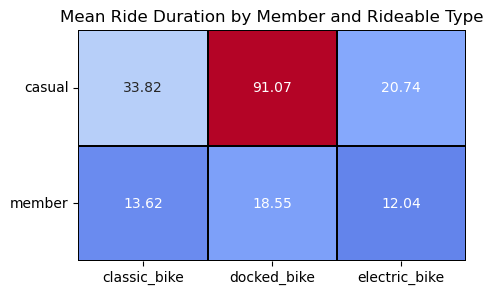

CPU times: user 6.06 s, sys: 720 ms, total: 6.78 s
Wall time: 6.78 s


In [12]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'ended_at',
    'rideable_type',
    'member_casual',
]

ride_time_comparison = data_pd[columns_to_keep].copy()

ride_time_comparison['started_at'] = ride_time_comparison['started_at'].str.split('.', expand=True)[0].copy()
ride_time_comparison['started_at'] = pd.to_datetime(ride_time_comparison['started_at'])

ride_time_comparison['ended_at'] = ride_time_comparison['ended_at'].str.split('.', expand=True)[0].copy()
ride_time_comparison['ended_at'] = pd.to_datetime(ride_time_comparison['ended_at'])

ride_time_comparison['ride_time'] = ride_time_comparison['ended_at'] - ride_time_comparison['started_at']
ride_time_comparison['ride_time'] = ride_time_comparison['ride_time']/pd.Timedelta(minutes=1)

ride_time_comparison = ride_time_comparison.groupby(
    ['member_casual', 'rideable_type']
).agg(
    mean_ride_time = ('ride_time', 'mean')
).reset_index().pivot(
    index='member_casual',
    columns='rideable_type',
    values='mean_ride_time',
)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.heatmap(
    data=ride_time_comparison,
    cmap='coolwarm',
    vmin=0,
    annot=True,
    fmt='.2f',
    cbar=False,
    linewidth=0.1,
    linecolor='k',
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(
    axis='y',
    labelrotation=0,
)
ax.set_title('Mean Ride Duration by Member and Rideable Type')

plt.show()

#### `polars` implementation

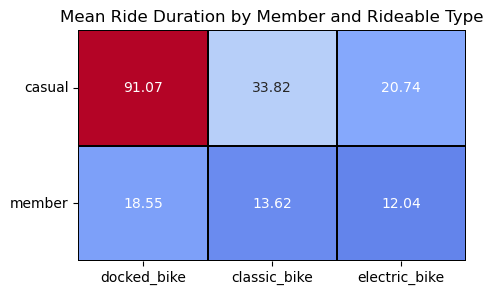

CPU times: user 1.91 s, sys: 557 ms, total: 2.47 s
Wall time: 221 ms


In [13]:
%%time

columns_to_keep = [
    'ride_id',
    'started_at',
    'ended_at',
    'rideable_type',
    'member_casual',
]

ride_time_comparison = data_pl.select(
    columns_to_keep
).with_columns(
    pl.col('started_at').str.split('.').list[0]
).with_columns(
    pl.col('started_at').str.to_datetime(format='%Y-%m-%d %H:%M:%S')
).with_columns(
    pl.col('ended_at').str.split('.').list[0]
).with_columns(
    pl.col('ended_at').str.to_datetime(format='%Y-%m-%d %H:%M:%S')
).with_columns(
    ride_time = ((pl.col('ended_at') - pl.col('started_at')).dt.total_seconds()/60)
).group_by(
    ['member_casual', 'rideable_type']
).agg(
    mean_ride_time = pl.col('ride_time').mean()
).pivot(
    index='member_casual',
    on='rideable_type',
    values='mean_ride_time',
).to_pandas().set_index(
    'member_casual'
).sort_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.heatmap(
    data=ride_time_comparison,
    cmap='coolwarm',
    vmin=0,
    annot=True,
    fmt='.2f',
    cbar=False,
    linewidth=0.1,
    linecolor='k',
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(
    axis='y',
    labelrotation=0,
)
ax.set_title('Mean Ride Duration by Member and Rideable Type')

plt.show()